<a href="https://colab.research.google.com/github/abhiksark/Diabetic-Retnopathy-Classification-ConvolutionalNeuralNetwork/blob/master/FastAi_DR_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authentication Establishment

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 18.7MB/s 


# Importing the Clear Data 

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
  
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
    100% |████████████████████████████████| 696.4MB 21kB/s 
1.0.0.dev20190319
True
True
    100% |████████████████████████████████| 17.3MB 2.1MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


## Taking the clean images which we saved in Google Drive in Earlier Notebook

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id_ = ""

downloaded = drive.CreateFile({'id':id_}) 
downloaded.GetContentFile('train.zip')   

### Unzipping the train.zip

In [0]:
%%capture
!unzip train.zip 

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

#### Creating a Validation folder from the Given Training Data

In [ ]:
!mkdir tmp/val
!mkdir tmp/val/0
!mkdir tmp/val/1
!mkdir tmp/val/2
!mkdir tmp/val/3
!mkdir tmp/val/4

In [ ]:
BASE_DIR = "tmp/train/"
NEW_DIR= "tmp/val/"

list_dir =  os.listdir(BASE_DIR)

for tdir in list_dir:
    list_images = os.listdir(BASE_DIR+tdir)
    to_val = random.sample(list_images, len(list_images)//5)
    for images in to_val:
        os.rename(BASE_DIR + str(tdir) + "/"+ images, NEW_DIR + str(tdir) + "/" + images )

In [0]:
!ls tmp

train  val


# Making Machine Learning Model

In [0]:
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch = densenet201                 # specify model architecture, densenet169 seems to perform well for this data but you could experiment
bs = 12 # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = 512                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'


In [0]:
PATH ='./tmp/'
tfms = get_transforms(do_flip=True,max_zoom=1.3)

data = ImageDataBunch.from_folder('./tmp',ds_tfms = tfms, valid='val', size=sz,bs=bs)

In [ ]:
data.normalize(imagenet_stats)

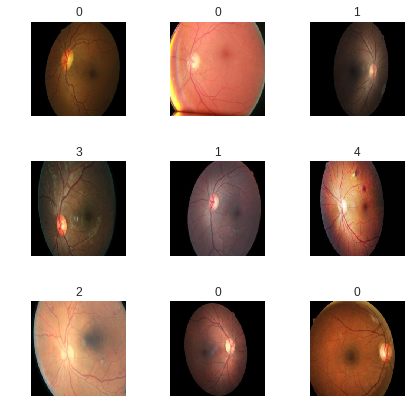

In [0]:
data.show_batch(rows=3, figsize=(6,6));

In [ ]:
def getLearner():
    return cnn_learner(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()

## Finding the correct Learning Rate 

In [0]:
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


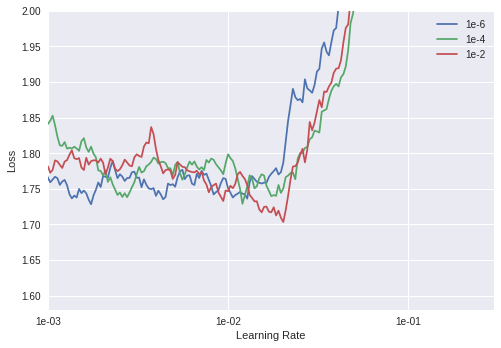

In [0]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 1.6
max_y = 2
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))